this competition https://www.kaggle.com/c/bird-or-aircraft

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
np.seed = 1324
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set(style="white")
%matplotlib inline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold

In [2]:
import cv2

import sys
import os

import keras

Using TensorFlow backend.


In [3]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import SpatialDropout2D
from keras.layers import Dropout
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD
from keras import regularizers

from keras.callbacks import TerminateOnNaN, ModelCheckpoint, LearningRateScheduler

from keras.utils.np_utils import to_categorical

import tensorflow as tf

from PIL import Image, ImageEnhance 

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
# from keras.datasets import cifar10

In [4]:
def submit_file(y_pred, filename):
    submit = pd.Series(y_pred.reshape(y_pred.shape[0]), name='target').replace({0: 'Bird', 1: 'Airplane'})
    submit.to_csv(filename +'.csv', index_label='id', header=True)
    print('file created')

In [5]:
#Функция для визуализации изображений
def viz_img(image, y=None):
    if y != None:
        plt.title(['Bird', 'Airplane'][int(y)])
    plt.imshow(image)
    plt.show()

In [6]:
def flip_image(array, show=False):
    '''for horizontal flip the picture'''
    image_obj = Image.fromarray(array.astype('uint8'))
    rotated_image = image_obj.transpose(Image.FLIP_LEFT_RIGHT)
    flipped_array = np.array(rotated_image, dtype=np.int)
    if show:
        plt.imshow(flipped_array)
    return flipped_array

def contrast_image(array, c_level=4.0, show=False):
    '''for contrast modification of the picture'''
    image_obj = Image.fromarray(array.astype('uint8'))
    enhancer = ImageEnhance.Contrast(image_obj)
    enhanced_im = enhancer.enhance(c_level)
    
    contrasted_array = np.array(enhanced_im, dtype=np.int)
    if show:
        plt.imshow(contrasted_array)
    return contrasted_array

In [7]:
train_x = pd.read_csv('../input/train_x.csv', index_col=0, header=None)
train_y = pd.read_csv('../input/train_y.csv', index_col=0)
test_x = pd.read_csv('../input/test_x.csv', index_col=0, header=None)

In [8]:
#3 слоя размером 32х32 они "вытянуты" в вектор 
train_x.shape, test_x.shape, train_y.shape

((7200, 3072), (4800, 3072), (7200, 1))

In [9]:
train_y.head(3)

,target
0,Bird
1,Airplane
2,Airplane


In [10]:
train_y.replace(['Bird', 'Airplane'], [0,1], inplace=True)

X = train_x.values.reshape(7200, 32, 32, 3)
X_test = test_x.values.reshape(4800, 32, 32, 3)
y_train = train_y.values

# x_test_padded = []
# for img in x_test:
#     img = np.pad(img,((2,2),(2,2),(0,0)), 'constant')
#     x_test_padded.append(img)
# x_test_padded = np.stack(x_test_padded)

# x_train_padded = []
# for img in x_train:
#     img = np.pad(img,((2,2),(2,2),(0,0)), 'constant')
#     x_train_padded.append(img)
# x_train_padded = np.stack(x_train_padded)

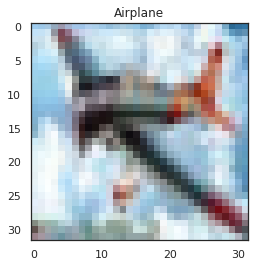

In [11]:
viz_img(X[100], y_train[100])

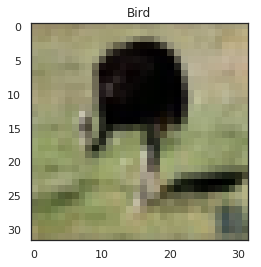

In [12]:
viz_img(X[452], y_train[452])

In [13]:
# Old Functions
def create_flip_set(X):
    my_flipped_imgs = []
    for img in X:
        nimg = flip_image(img)
        my_flipped_imgs.append(nimg)
    return np.stack(my_flipped_imgs)

def create_contrast_set(X):
    my_contrasted_imgs = []
    for img in X:
        nimg = contrast_image(img)
        my_contrasted_imgs.append(nimg)
    return np.stack(my_contrasted_imgs)

In [14]:
# callbacks = [
#     TerminateOnNaN(), ModelCheckpoint('bird_plane_lenet.hdf5', verbose=1, monitor='val_loss', save_best_only=True),
# #    LearningRateScheduler(step_decay)
# ]

------

In [15]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate
 

In [16]:
X = X.astype('float32')
X_test = X_test.astype('float32')
x_train, x_test, y_train, y_test = train_test_split(X, y_train, test_size=0.3, random_state=12000)

In [17]:
 #z-score
mean = np.mean(x_train, axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean) / (std + 1e-7)
x_test = (x_test-mean) / (std + 1e-7)
X_test = (X_test-mean) / (std + 1e-7)

In [18]:
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), 
                                            input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
 
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2

In [19]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [20]:
#training
batch_size = 64
 
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='binary_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size, epochs=125,
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

Instructions for updating:
Use tf.cast instead.
Epoch 1/125
78/78 [==============================] - 5s 60ms/step - loss: 0.7155 - acc: 0.7526 - val_loss: 0.5675 - val_acc: 0.8361
Epoch 2/125
78/78 [==============================] - 2s 28ms/step - loss: 0.5281 - acc: 0.8009 - val_loss: 0.4830 - val_acc: 0.8556
Epoch 3/125
78/78 [==============================] - 2s 29ms/step - loss: 0.4781 - acc: 0.8213 - val_loss: 0.4207 - val_acc: 0.8583
Epoch 4/125
78/78 [==============================] - 2s 29ms/step - loss: 0.4483 - acc: 0.8395 - val_loss: 0.4720 - val_acc: 0.8389
Epoch 5/125
78/78 [==============================] - 2s 29ms/step - loss: 0.4168 - acc: 0.8507 - val_loss: 0.3733 - val_acc: 0.8727
Epoch 6/125
78/78 [==============================] - 2s 30ms/step - loss: 0.3994 - acc: 0.8506 - val_loss: 0.3690 - val_acc: 0.8778
Epoch 7/125
78/78 [==============================] - 2s 29ms/step - loss: 0.3680 - acc: 0.8665 - val_loss: 0.6619 - val_acc: 0.7972
Epoch 8/125
78/78 [=========

Text(0.5, 1.0, 'Accuracy')

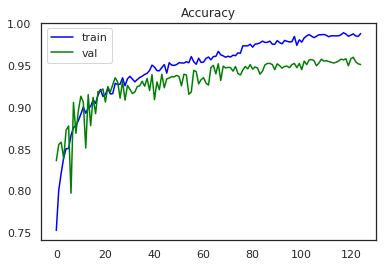

In [21]:
plt.plot(model.history.history['acc'], c='blue', label='train')
plt.plot(model.history.history['val_acc'], c='green', label='val')
plt.legend()
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

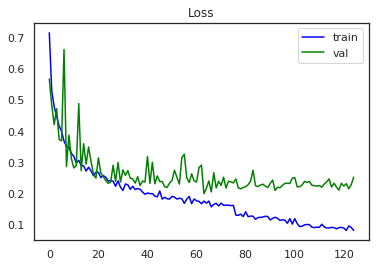

In [22]:
plt.plot(model.history.history['loss'], c='blue', label='train')
plt.plot(model.history.history['val_loss'], c='green', label='val')
plt.legend()
plt.title('Loss')

In [23]:
y_pred = model.predict_classes(X_test)

In [24]:
submit_file(y_pred, 'best')

file created


In [25]:
#save model to disk
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('model.h5') 